In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats import gamma, uniform, loguniform

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
CONTINUOUS_VARIABLES = ['area']
ORDINAL_VARIABLES = ['bedrooms', 'bathrooms', 'stories', 'parking', 'furnishingstatus']
ORDINAL_CATEGORIES = []
DUMMY_VARAIBLES = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                   'airconditioning', 'prefarea']
RANDOM_SEED = 19

In [3]:
# **********************
# USER DEFINED FUNCTIONS
# **********************
def get_info(df: pd.DataFrame):
    """
    Function that return a pandas.DataFrame object with
    some statistical information to have an initial
    analysis of the input DataFrame.

    Arguments:
    ---
    * df (pandas.DataFrame), DataFrame to analyse.
    """
    return (
        pd.concat(
            [
                df.dtypes.rename("dtype"),
                df.nunique().rename("n_unique"),
                df.isna().sum().rename("nan_values"),
                df.describe().transpose()
            ],
            axis=1
        )
    )

def evaluate_regression_model(model, dataset):
    """
    Function to evaluate a regression model with the method
    predict to a specific dataset. The dataset has to be a
    tuple of an matrix of fetures and an array with values
    of the target variable.
    """
    X, y = dataset
    y_pred = model.predict(X)

    return mean_squared_error(y, y_pred), r2_score(y, y_pred)

def cv_housing(models, model_names, dataset, preprocessor, n_splits=5, rnd_seed=19):

    X, y = dataset


    kf = KFold(n_splits=n_splits, shuffle=True, random_state=rnd_seed)

    metrics = {}

    for model, mdl_name in zip(models, model_names):

        # MSE
        train_mses = []
        test_mses = []

        # scores
        train_scores = []
        test_scores = []
        
        # compute scores for 5-fold
        for train_index, test_index in kf.split(X):
            # split training and test
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            X_train = preprocessor.fit_transform(X_train)
            X_test = preprocessor.transform(X_test)
            
            model.fit(X_train, y_train)

            train_mse, train_score = evaluate_regression_model(model, (X_train, y_train))
            train_mses.append(train_mse)
            train_scores.append(train_score)

            test_mse, test_score = evaluate_regression_model(model, (X_test, y_test))
            test_mses.append(test_mse)
            test_scores.append(test_score)

        metrics[f"train_mse_{mdl_name}"] = np.array(train_mses)
        metrics[f"train_scores_{mdl_name}"] = np.array(test_scores)
        metrics[f"test_mse_{mdl_name}"] = np.array(train_mses)
        metrics[f"test_scores_{mdl_name}"] = np.array(test_scores)
    
    return metrics

def plot_average_obs(input_df, target, feature, ax, flag_cat=True, reg_order=1, flag_regr=True):
    """
    Function to show the observed average target value with respect to a feature.
    
    Arguments:
    ---
    - input_df (pandas.DataFrame), input dataset with target and feature values.
    - target (str), name of the target variable.
    - feature (str), name of the feature varaible.
    - ax (matplotlib.axes.Axes), axes where plot the chart.
    - flag_cat (bool, default=True), if True the feature is categorical.
    - reg_order (int, default=1), indicates the polynomial of the feature.
    - flag_regr (bool, defaul=True), if True plot the regression curve.
    """
    hist_df = input_df.copy()

    if not flag_cat:
        _, bins = np.histogram(hist_df[feature])
        indices = np.digitize(hist_df[feature], bins=bins)
        map_obj = map(lambda x: bins[x-1], indices)
        hist_df[feature] = np.array(map_obj)

    avg_df = hist_df.groupby(feature)[target].mean().reset_index()

    sns.histplot(input_df, x=feature, ax=ax, zorder=2, alpha=0.5)
    ax.grid()
    ax2 = ax.twinx()
    sns.lineplot(avg_df, x=feature, y=target, ax=ax2, color='orange', marker='o', label='observed')
    if flag_regr:
        sns.regplot(data=avg_df, x=feature, y=target,
                    order=reg_order, scatter=False, ci=None, ax=ax2,
                    line_kws={'linestyle': '--', 'color': 'red'},
                    label='estimated')
    plt.legend()
    return None

def apply_random_search(params_dist, model_pipeline, dataset, random_state=19, 
                        n_iter=100, n_splits=5, scoring='neg_mean_squared_error'):
   """
   Function to apply a random search with cross validation.
   """

   X, y = dataset
   
   random_search = RandomizedSearchCV(
      model_pipeline,
      param_distributions=params_dist,
      n_iter=n_iter,
      cv=KFold(n_splits=n_splits,
               shuffle=True,
               random_state=random_state),
      random_state=random_state,
      scoring=scoring,
      n_jobs=-1
   )
   
   random_search.fit(X, y)

   return random_search.best_estimator_

# 1. Data exploaration

The first step when starting a new ML project is to explore the data. The goal is to understand the distribution of the target variable and its relationship to features. Moreover, it is necessary to understand how to treat different variables depending on the data type and their frequency.

In [4]:
input_df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv")
print(f"The number of duplicated rows is: {input_df.duplicated().sum()}")

for var in ORDINAL_VARIABLES+DUMMY_VARAIBLES:
    if var in ORDINAL_VARIABLES:
        input_df[var] = input_df[var].astype('category')
        ORDINAL_CATEGORIES.append(input_df[var].sort_values().unique().to_list())
    else:
        input_df[var] = input_df[var].astype('uint8')

info_input_df = get_info(input_df)
info_input_df

The number of duplicated rows is: 0


,dtype,n_unique,nan_values,count,mean,std,min,25%,50%,75%,max
price,int64,219,0,545.000,4766729.248,1870439.616,1750000.000,3430000.000,4340000.000,5740000.000,13300000.000
area,int64,284,0,545.000,5150.541,2170.141,1650.000,3600.000,4600.000,6360.000,16200.000
bedrooms,category,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,category,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stories,category,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mainroad,uint8,2,0,545.000,0.859,0.349,0.000,1.000,1.000,1.000,1.000
guestroom,uint8,2,0,545.000,0.178,0.383,0.000,0.000,0.000,0.000,1.000
basement,uint8,2,0,545.000,0.350,0.478,0.000,0.000,0.000,1.000,1.000
hotwaterheating,uint8,2,0,545.000,0.046,0.209,0.000,0.000,0.000,0.000,1.000
airconditioning,uint8,2,0,545.000,0.316,0.465,0.000,0.000,0.000,1.000,1.000


The dataset does not contain duplicated rows and the table above shows the input data does not have missing values. Hence, it is not necessary to drop duplicates and impute missing values.

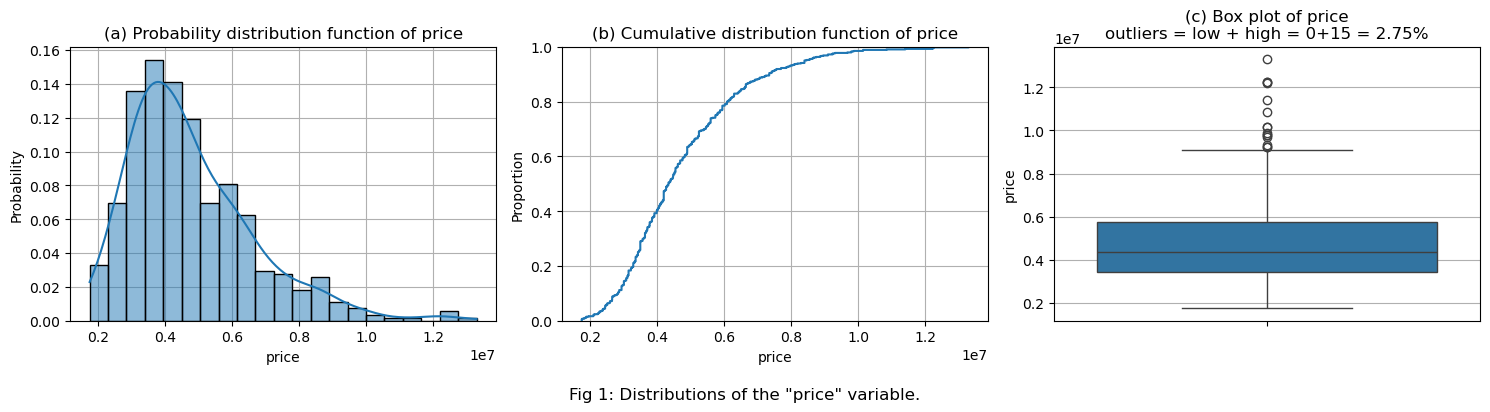

In [5]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4), tight_layout=True)
ax_1.grid()
ax_2.grid()
ax_3.grid()
sns.histplot(input_df, x='price', stat='probability', kde=True, ax=ax_1, zorder=2)
sns.ecdfplot(input_df, x='price', stat='proportion', ax=ax_2, zorder=2)
sns.boxplot(input_df, y='price', ax=ax_3, zorder=2)

Q1 = np.quantile(input_df.price, q=.25)
Q3 = np.quantile(input_df.price, q=.75)
IQR = Q3-Q1
low_whisker = Q1-1.5*IQR
high_whisker = Q3+1.5*IQR
n_lower_outliers = input_df[input_df.price<=low_whisker].shape[0]
n_higher_outliers = input_df[input_df.price>=high_whisker].shape[0]

ax_1.set(title="(a) Probability distribution function of price")
ax_2.set(title="(b) Cumulative distribution function of price")
ax_3.set(title=f"(c) Box plot of price\noutliers = low + high = {n_lower_outliers}+{n_higher_outliers} \
= {(n_lower_outliers+n_higher_outliers)/input_df.shape[0]:.2%}")

fig.text(0.5, -0.05, 'Fig 1: Distributions of the "price" variable.', ha='center', fontsize=12)
plt.show()

## 1.1 Target distribution and outliers

Figure 1 shows the distribution of `price` in different ways. The cumulative distribution function (aka _cdf_) graph (1.b) shows the $80\%$ of the house in the dataset have a price lower that $600,000.00$ (the currency is not given). The box plot shows the points that are considered outliers with the interquartile range (aka _IQR_). The formula to apply is:
$$
    outlier_{low} = Q1 - 1.5 \cdot IQR;\ where\ Q1 = 25^{th} percentile\\
    outlier_{high} = Q3 + 1.5 \cdot IQR;\ where\ Q3 = 75^{th} percentile \tag{1}
$$

There are zero outliers in the dataset with price values below $outlier_{low}$ and 15 outliers with price values above $outlier_{high}$ corresponding to $2.75\%$. The model should have only data that are not considerd outliers. Hence, it is possible to remove those datapoints.

Figure 1.a shows the probability distribution function (aka _pdf_) of the observations. It is possible to assume the data distribution can be represented by a gamma distribution. Hence, we can produce a Q-Q plot to visualize if that assumption is resonable or not.

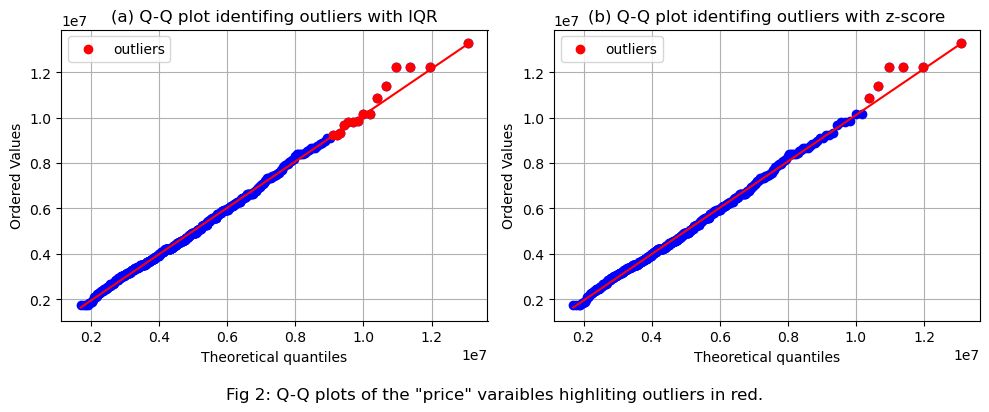

In [6]:
# get data of target varaible
# sort the data since the outputs of function
# stats.probplot() are sorted
data = input_df.price.sort_values().values

# get the params of gamma function
params = gamma.fit(data)

# compute z-scores to identify outliers
z_scores = stats.zscore(data)
rule_z_score_outliers = (z_scores > 3) | (z_scores < -3)
outliers_z_score = data[rule_z_score_outliers]

# compute IQR to identify outliers
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
rule_IQR_outliers = (data < lower_bound) | (data > upper_bound)
outliers = data[rule_IQR_outliers]

# Q-Q Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), tight_layout=True)
res = stats.probplot(data, dist="gamma", sparams=params, plot=ax1)
stats.probplot(data, dist="gamma", sparams=params, plot=ax2)

# theoretical and observed quantiles
theoretical_quantiles = res[0][0]
observed_quantiles = res[0][1]

# Plot degli outliers in rosso
ax1.scatter(theoretical_quantiles[rule_IQR_outliers],
            observed_quantiles[rule_IQR_outliers],
            color='red', zorder=2, label='outliers')
ax2.scatter(theoretical_quantiles[rule_z_score_outliers],
            observed_quantiles[rule_z_score_outliers],
            color='red', zorder=2, label='outliers')

ax1.set(title="(a) Q-Q plot identifing outliers with IQR")
ax1.legend()
ax1.grid()

ax2.set(title="(b) Q-Q plot identifing outliers with z-score")
ax2.legend()
ax2.grid()

fig.text(0.5, -0.05, 'Fig 2: Q-Q plots of the "price" varaibles highliting outliers in red.', ha='center', fontsize=12)
plt.show()

Figure 2 shows the _Q-Q plot_ of the target variable `price`. It shows the assumption of the gamma distribution is true, except in some points that can be considered as outliers.

In order to identify outliers we have used two different approches:
* Interquantile range (aka _IQR_) that identify the outliers using the equation 1. This method does not make any assumption on the data distribution. Figure 2.a shows the results.
* Z-score, this method assume the data are normally distributed. Hence, in our case it is a wrong assumption. However, it identify a sub-set of outliers identified by the _IQR_ method. Figure 2.b shows the results.

Due to a data scarcity in this project the method of z-score is the one chosed.

In [7]:
data = input_df.price.values
z_scores = stats.zscore(data)
rule_z_score_no_outliers = (z_scores < 3) & (z_scores > -3)

no_outliers_df = input_df.copy()
no_outliers_df = no_outliers_df[rule_z_score_no_outliers]

print(f"The number of observation of the original dataset is: {input_df.shape[0]}")
print(f"The system have identified {int(input_df.shape[0])-int(no_outliers_df.shape[0])} outliers.")
print(f"The number of observation of the cleaned dataset is: {no_outliers_df.shape[0]}")
get_info(no_outliers_df)

The number of observation of the original dataset is: 545
The system have identified 6 outliers.
The number of observation of the cleaned dataset is: 539


,dtype,n_unique,nan_values,count,mean,std,min,25%,50%,75%,max
price,int64,214,0,539.000,4685700.260,1712754.396,1750000.000,3430000.000,4319000.000,5696250.000,10150000.000
area,int64,280,0,539.000,5117.412,2156.687,1650.000,3577.000,4510.000,6360.000,16200.000
bedrooms,category,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,category,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stories,category,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mainroad,uint8,2,0,539.000,0.857,0.350,0.000,1.000,1.000,1.000,1.000
guestroom,uint8,2,0,539.000,0.178,0.383,0.000,0.000,0.000,0.000,1.000
basement,uint8,2,0,539.000,0.347,0.476,0.000,0.000,0.000,1.000,1.000
hotwaterheating,uint8,2,0,539.000,0.046,0.211,0.000,0.000,0.000,0.000,1.000
airconditioning,uint8,2,0,539.000,0.310,0.463,0.000,0.000,0.000,1.000,1.000


## 1.2 Feature distributions

In this section we explore feature distributions and possible multicollinearity betweeen features.

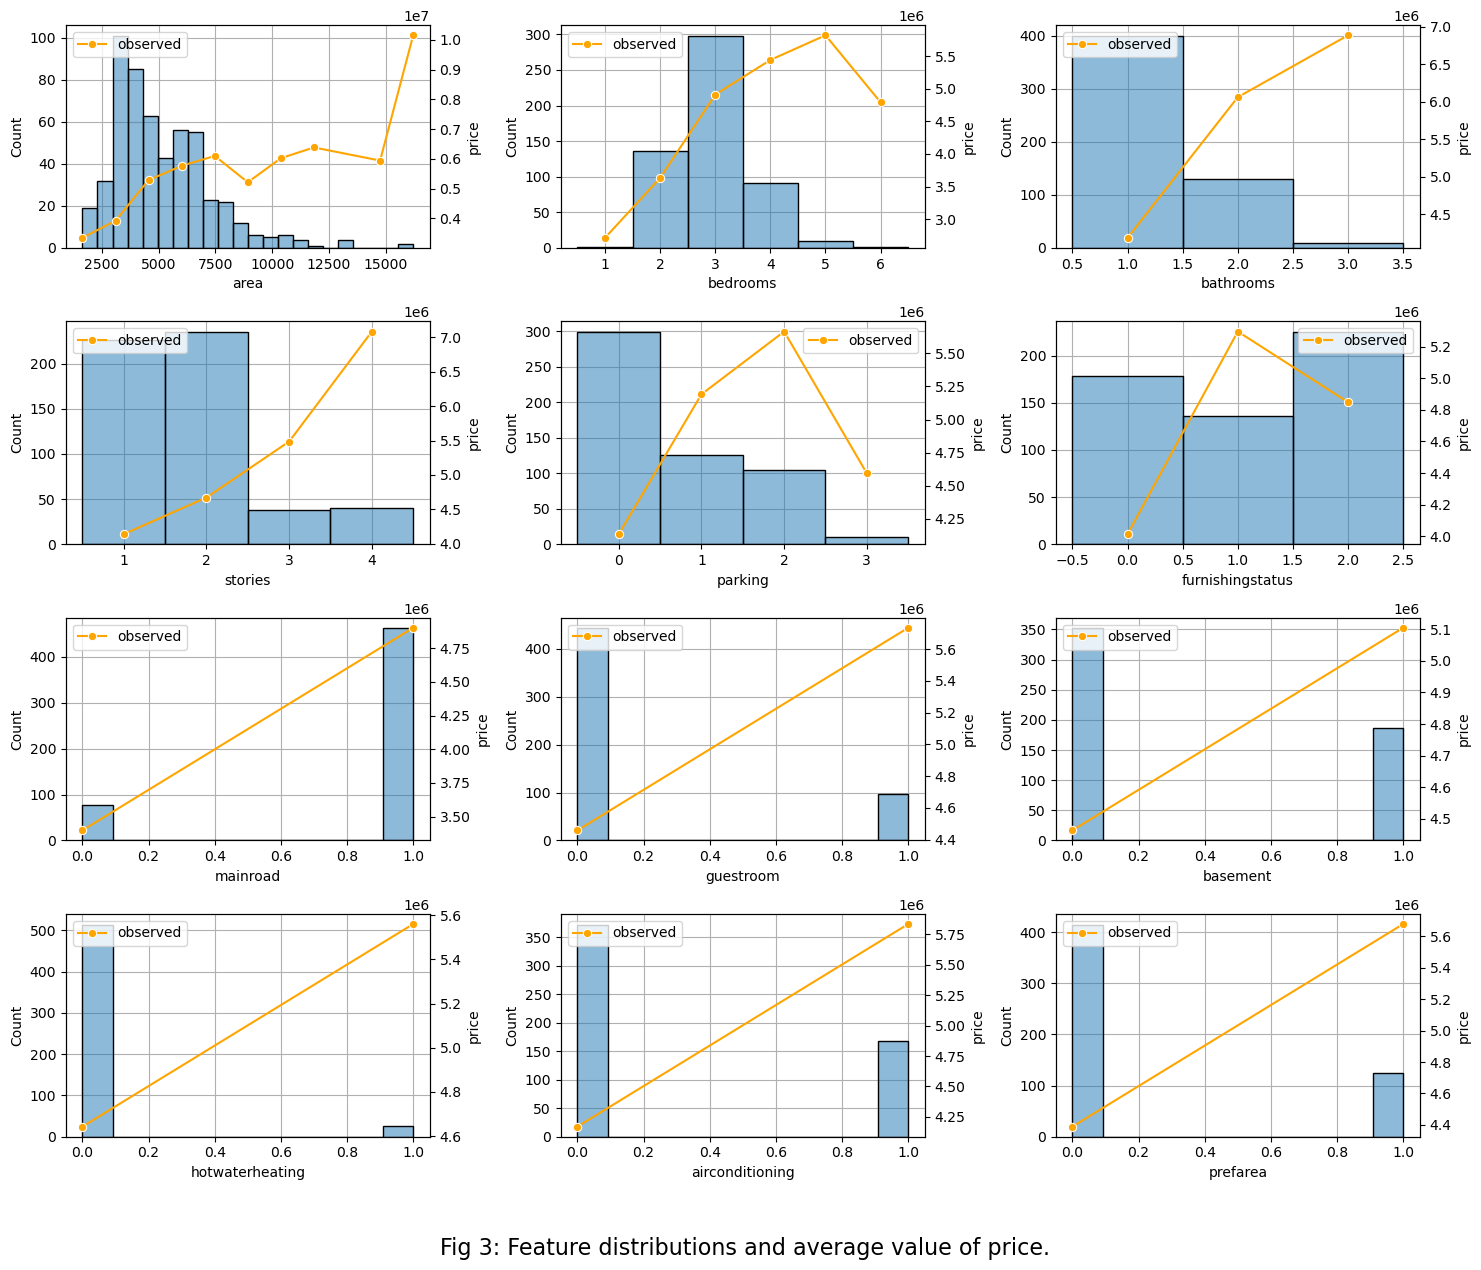

In [8]:
NCOLS = 3
NROWS = int(np.ceil(len(CONTINUOUS_VARIABLES+ORDINAL_VARIABLES+DUMMY_VARAIBLES)/NCOLS))
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(NCOLS*5, NROWS*3), tight_layout=True)

for var, ax in zip(CONTINUOUS_VARIABLES+ORDINAL_VARIABLES+DUMMY_VARAIBLES, axs.ravel()):
    if var in CONTINUOUS_VARIABLES:
        plot_average_obs(input_df=no_outliers_df,
                        target='price',
                        feature=var,
                        ax=ax,
                        flag_cat=False,
                        flag_regr=False,
                        reg_order=1)
    else:
        plot_average_obs(input_df=no_outliers_df,
                        target='price',
                        feature=var,
                        ax=ax,
                        flag_cat=True,
                        flag_regr=False,
                        reg_order=1)
        
# set axis off
for ax in axs.ravel()[len(CONTINUOUS_VARIABLES+ORDINAL_VARIABLES+DUMMY_VARAIBLES):]:
    ax.set_axis_off()

fig.text(0.5, -0.05, 'Fig 3: Feature distributions and average value of price.', ha='center', fontsize=16)
plt.show()

Figure 3 show the approximation of the feature distributions. In particular, the dataset has only one continuous feature `area`, five ordinal varaibles (`bedrooms`, `bathrooms`, `stories`, `parking`, `furnishingstatus`), and six dummy variables (`mainroad`, `guestroom`, `basement`, `hotwaterheating`, `airconditioning`, `prefarea`).

The feature `area` has a positive correlation with the `price` of the house. That is a characteristic that we expect, since the real-estate market define the house price by square-meter in some regions of a specific country. However, that is not the only characteristic that can influance the house price. To see the correlation between features and `price` it is useful to look the correlation matrix.

## 1.3 Feature preprocessing

In [37]:
# create features and target array
X = no_outliers_df.drop('price', axis=1)
y = no_outliers_df.price

# define pipeline to pre-process continuous variables
continuous_pipeline = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

# preprocessing for ordinal variables
ordinal_pipeline = Pipeline(steps=[
    ("ohe", OneHotEncoder(categories=ORDINAL_CATEGORIES))
])

# define preprocessiong 
preprocessor = ColumnTransformer(transformers=[
    ("num", continuous_pipeline, CONTINUOUS_VARIABLES),
    ("ord", ordinal_pipeline, ORDINAL_VARIABLES),
    ("dum", "passthrough", DUMMY_VARAIBLES)
])

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED)

print(X_train.shape, X_test.shape)

# pre-process, fit only training data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# get feature names
feature_names = list(map(lambda x: x.split('__')[1], preprocessor.get_feature_names_out()))

# create traing dataframe
train_df = pd.concat([pd.Series(data=y_train, name='price').reset_index(drop=True),
                      pd.DataFrame(data=X_train, columns=feature_names)],
                      axis=1)

# create testing dataframe
test_df = pd.concat([pd.Series(data=y_test, name='price').reset_index(drop=True),
                      pd.DataFrame(data=X_test, columns=feature_names)],
                      axis=1)

(404, 12) (135, 12)
(404, 29) (135, 29) (404,) (135,)


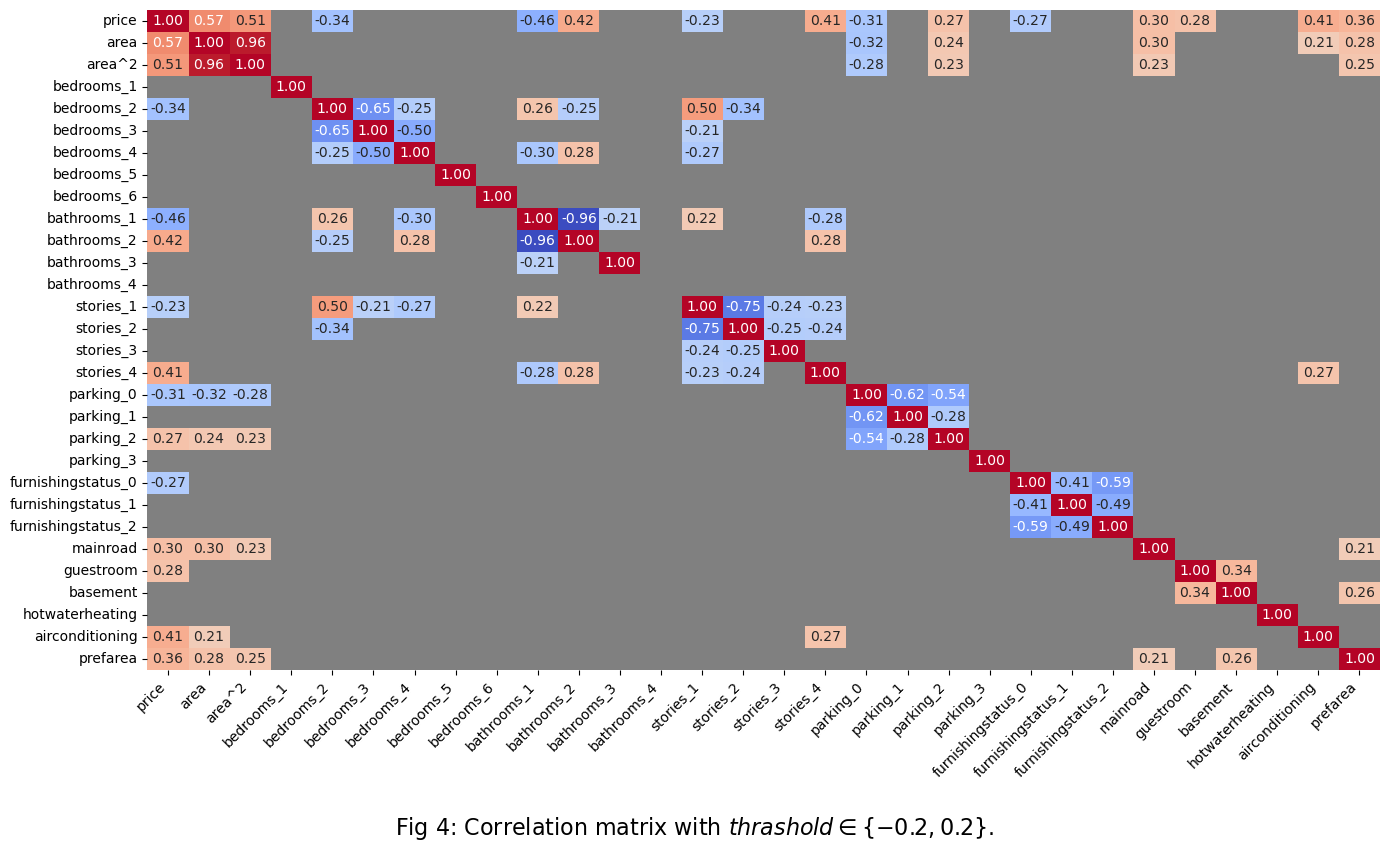

In [38]:
# define correlation thrashold
CORR_THRASHOLD = 0.2

# create correlation matrix
corr_matrix = train_df.corr(numeric_only=True)
mask = np.where((corr_matrix < CORR_THRASHOLD) & (corr_matrix>-CORR_THRASHOLD), False, True)
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='grey')

# create correlation figure
fig = plt.figure(figsize=(14,8), tight_layout=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=~mask, cmap=cmap, cbar=False)
plt.xticks(rotation=45, ha='right')
fig.text(0.5, -0.05, r'Fig 4: Correlation matrix with $thrashold \in \{-0.2, 0.2\}$.', ha='center', fontsize=16)
plt.show()

Figure 4 shows the correlation matrix where the results are shown only for positive correlation higher than 0.2 and negative correlation lower than 0.2. The dataset does not present a feature with a strong correlation with the target variable. The `area` variable is the one with the strongest correlation with the `price` with a positive linear correlation. 

There are features with a strong correlation. Thus, there is a multicollinearity issue. For instance, `bathrooms_1` and `bathrooms_2` shows a strong negative linear correlations. Features with a strong correlation can drive the model to have a large coefficient and to overfit the training model. However, the linear regression models `Lasso`, `Ridge`, and `ElasticNet` use regularization to reduce weights and reduce the overfitting.

# 2. Model development

This section presents the comparison between different linear regression models. In particular, the models adopted are:
* `Lasso()`, it implement regularization _L1_.
* `Ridge()`, it implement regularization _L2_.
* `ElasticNet()`, it implement both regularization _L1_ and _L2_ with a fixed ration.

Regularization is a technique used to prevent overfitting by adding a term to the cost of the model that penalizes large coefficients. _L1_ regularization add to the cost function the sum of absolute value of coefficients multiplied by a factor $\lambda$, whereas the _L2_ the sum of squared value of coefficents. Hence, in the case of _L1_ variables with a higher coefficients are penalised more respect to the case of _L2_ regularization.

## 2.1 Methodology

All the training and testing of the models adopted in this notebook follow the best practise presented in [chapter 10 of the guide of scikit-learn](https://scikit-learn.org/1.5/common_pitfalls.html). The models compared are a base form of Lasso, Ridge, and ElasticNet and a _best_ form of the same model where a `RandomizedSearchCV()` is used to idetinfy the best parameters in a specific space for each parameter.

The objective is to obtain the lower value of mean squared error (aka _MSE_). Hence, in the random search the `scoring` parameter is set with value `neg_mean_squared_error`.

In [39]:
# ***********
# BASE MODELS
# ***********
# Turn off warnings
# the model tested are simple and can not converge
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    lasso_base = Lasso(alpha=1.0)
    ridge_base = Ridge(alpha=1.0)
    elNet_base = ElasticNet(alpha=1.0, l1_ratio=0.5)
    models = [lasso_base, ridge_base, elNet_base]
    model_names = ["Lasso", "Ridge", "ElasticNet"]

    metrics = cv_housing(models,
                         model_names,
                         (X, y),
                         preprocessor,
                         n_splits=5,
                         rnd_seed=RANDOM_SEED)
    
    metrics_base_df = pd.DataFrame(metrics)
    info_metrics_base_df = get_info(metrics_base_df)

# Reset warnings
warnings.resetwarnings()

# ***********
# BEST MODELS
# ***********
# Lasso
best_lasso_model = apply_random_search(params_dist={'lasso__alpha': loguniform(1e-4, 10),
                                                   'lasso__max_iter': np.arange(1_000, 1_000_000, 50),
                                                   'lasso__tol': uniform(0.00001, 0.1)},
                                       model_pipeline=Pipeline(steps=[
                                          ("pre", preprocessor),
                                          ("lasso", Lasso())
                                       ]),
                                       dataset=(X, y),
                                       random_state=RANDOM_SEED)
lasso_mse, lasso_r2 = evaluate_regression_model(best_lasso_model['lasso'],
                                                (X_test, y_test))

# Ridge
best_ridge_model = apply_random_search(params_dist={'ridge__alpha': loguniform(1e-4, 10),
                                                   'ridge__max_iter': np.arange(1_000, 1_000_000, 50),
                                                   'ridge__tol': uniform(0.00001, 0.1)},
                                       model_pipeline=Pipeline(steps=[
                                          ("pre", preprocessor),
                                          ("ridge", Ridge())
                                       ]),
                                       dataset=(X, y),
                                       random_state=RANDOM_SEED)
ridge_mse, ridge_r2 = evaluate_regression_model(best_ridge_model['ridge'],
                                                (X_test, y_test))

# ElasticNet
best_elNet_model = apply_random_search(params_dist={'elNet__alpha': loguniform(1e-4, 10),
                                                   'elNet__max_iter': np.arange(1_000, 1_000_000, 50),
                                                   'elNet__l1_ratio': np.random.uniform(low=0.1, high=1.0, size=10_000),
                                                   'elNet__tol': uniform(0.00001, 0.1)},
                                       model_pipeline=Pipeline(steps=[
                                          ("pre", preprocessor),
                                          ("elNet", ElasticNet())
                                       ]),
                                       dataset=(X, y),
                                       random_state=RANDOM_SEED)
elNet_mse, elNet_r2 = evaluate_regression_model(best_elNet_model['elNet'],
                                                (X_test, y_test))

lasso_best = best_lasso_model['lasso']
ridge_best = best_ridge_model['ridge']
elNet_best = best_elNet_model['elNet']

best_models = [lasso_best, ridge_best, elNet_best]
best_model_names = ["Lasso_best", "Ridge_best", "ElasticNet_best"]

best_metrics = cv_housing(best_models, best_model_names, (X, y), preprocessor, n_splits=5, rnd_seed=RANDOM_SEED)
metrics_best_df = pd.DataFrame(best_metrics)
info_metrics_best_df = get_info(metrics_best_df)

/Users/lorenzopusateri/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+13, tolerance: 9.486e+12
  model = cd_fast.enet_coordinate_descent(
/Users/lorenzopusateri/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+13, tolerance: 9.570e+12
  model = cd_fast.enet_coordinate_descent(
/Users/lorenzopusateri/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

## 2.2 Performance analysis

In [40]:
print("Tab 1: Summary of base models")
display(info_metrics_base_df[['mean', 'min', 'max']])

print("\nTab 2: Summary of best models")
display(info_metrics_best_df[['mean', 'min', 'max']])

Tab 1: Summary of base models


,mean,min,max
train_mse_Lasso,872847978686.450,855571736873.537,894804635240.769
train_scores_Lasso,0.652,0.588,0.712
test_mse_Lasso,872847978686.450,855571736873.537,894804635240.769
test_scores_Lasso,0.652,0.588,0.712
train_mse_Ridge,873986589545.071,856561750284.405,896054962363.281
train_scores_Ridge,0.655,0.588,0.714
test_mse_Ridge,873986589545.071,856561750284.405,896054962363.281
test_scores_Ridge,0.655,0.588,0.714
train_mse_ElasticNet,1310069370670.312,1298969459434.234,1329447686736.044
train_scores_ElasticNet,0.530,0.514,0.543



Tab 2: Summary of best models


,mean,min,max
train_mse_Lasso_best,872848056082.806,855571816916.480,894804700756.137
train_scores_Lasso_best,0.652,0.588,0.712
test_mse_Lasso_best,872848056082.806,855571816916.480,894804700756.137
test_scores_Lasso_best,0.652,0.588,0.712
train_mse_Ridge_best,879001063976.312,860889716028.892,901643912529.070
train_scores_Ridge_best,0.656,0.589,0.713
test_mse_Ridge_best,879001063976.312,860889716028.892,901643912529.070
test_scores_Ridge_best,0.656,0.589,0.713
train_mse_ElasticNet_best,878758464109.552,860675745218.679,901379820575.365
train_scores_ElasticNet_best,0.656,0.589,0.713


Table 1 shows the _MSE_ and $R^2score$ for the baseline models, while Table 2 presents the same metrics for the best models. Metrics are comperable except for the baseline model of `ELasticNet`, where the average value of _MSE_ for the baseline model is equal to $13.13e^{11}$ and for the best model is $8.58e^{11}$. The model with the lowest value of MSE is best Lasso with an average $MSE \approx 8.53e^{11}$, that is a $RMSE \approx 923,902.50$.

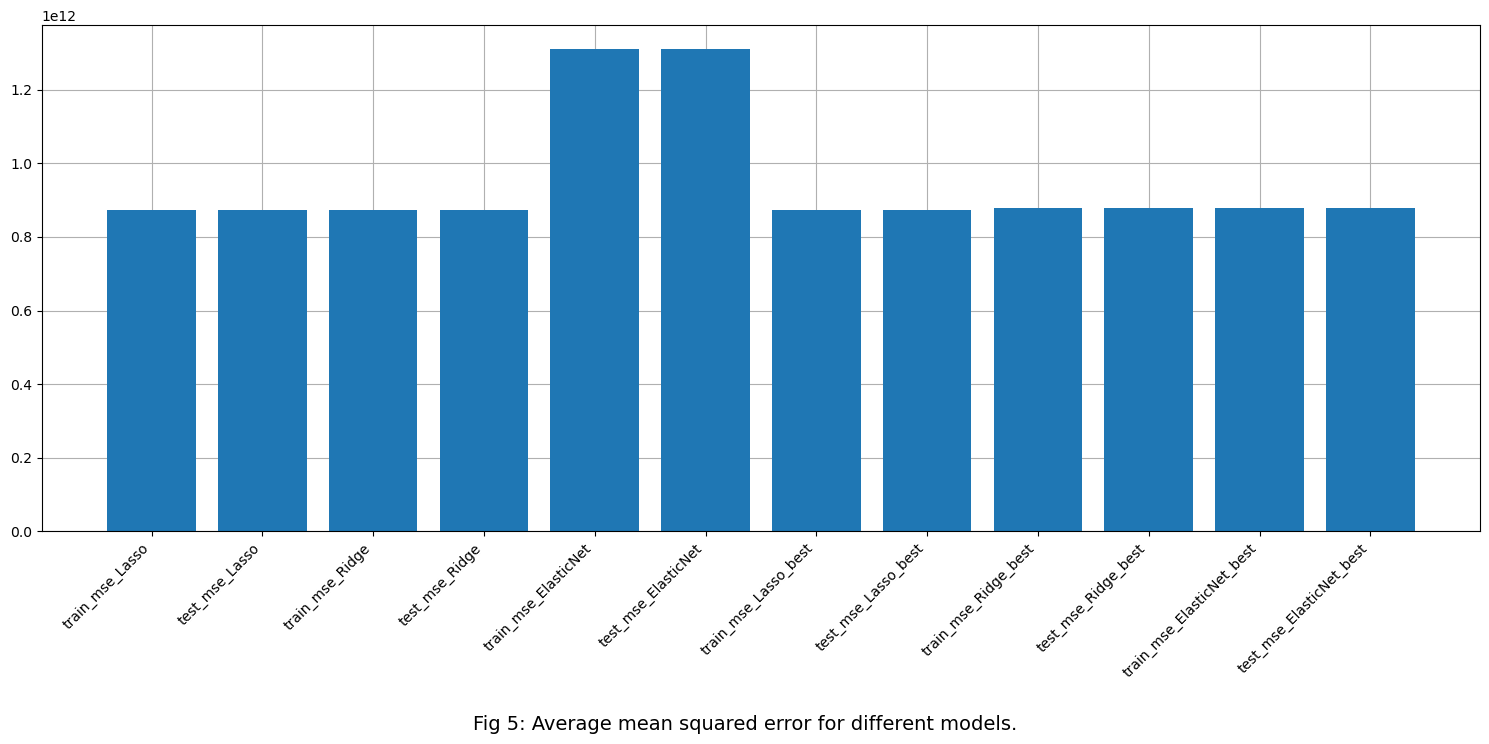

In [41]:
mean_metrics_s = pd.concat([info_metrics_base_df.loc[info_metrics_base_df.index.str.contains('mse'), 'mean'],
                             info_metrics_best_df.loc[info_metrics_base_df.index.str.contains('mse'), 'mean']], axis=0)

fig = plt.figure(figsize=(15, 7), tight_layout=True)
plt.bar(list(mean_metrics_s.index), mean_metrics_s.values, zorder=2)
plt.grid()
plt.xticks(rotation=45, ha='right')
fig.text(0.5, -0.05, "Fig 5: Average mean squared error for different models.", ha='center', fontsize=14)
plt.show()

Figure 5 shows that almost all the models have a similar MSE except for the base `ElasticNet`. However, it is interesting to visualise if the same type of model from base to best form have a different weigths of parameter. Section 2.3 presents the coefficiente analysis.

## 2.3 Coefficient analysis

Figure 6 shows graphs for coefficient analysis between the baseline version of a model respect to the _best_ version of it.

Figure 6.a presents the results for Lasso model. Coefficients have comperable weights, `bathrooms_4` is the only feature with coefficient zero, that is also true for Figures 6.b and 6.c. Moreover, the three variables with larger coefficients are `bathrooms_1`, `bathrooms_3`, and `hotwaterheating`. Instead, coefficients presented in Figure 6.b are slightly differrent from the baseline model and the best version, and the coefficients of the best version of the `Ridge` model are comperable with the one of the `ElasticNet` (Figure 7).

Figure 6.c is the only graph that shows a huge difference of coefficients of the model between the baseline version and the best version. In fact, comparing performance results of the `ElasticNet` model using Tab1 and Tab2 there is a substantial difference.

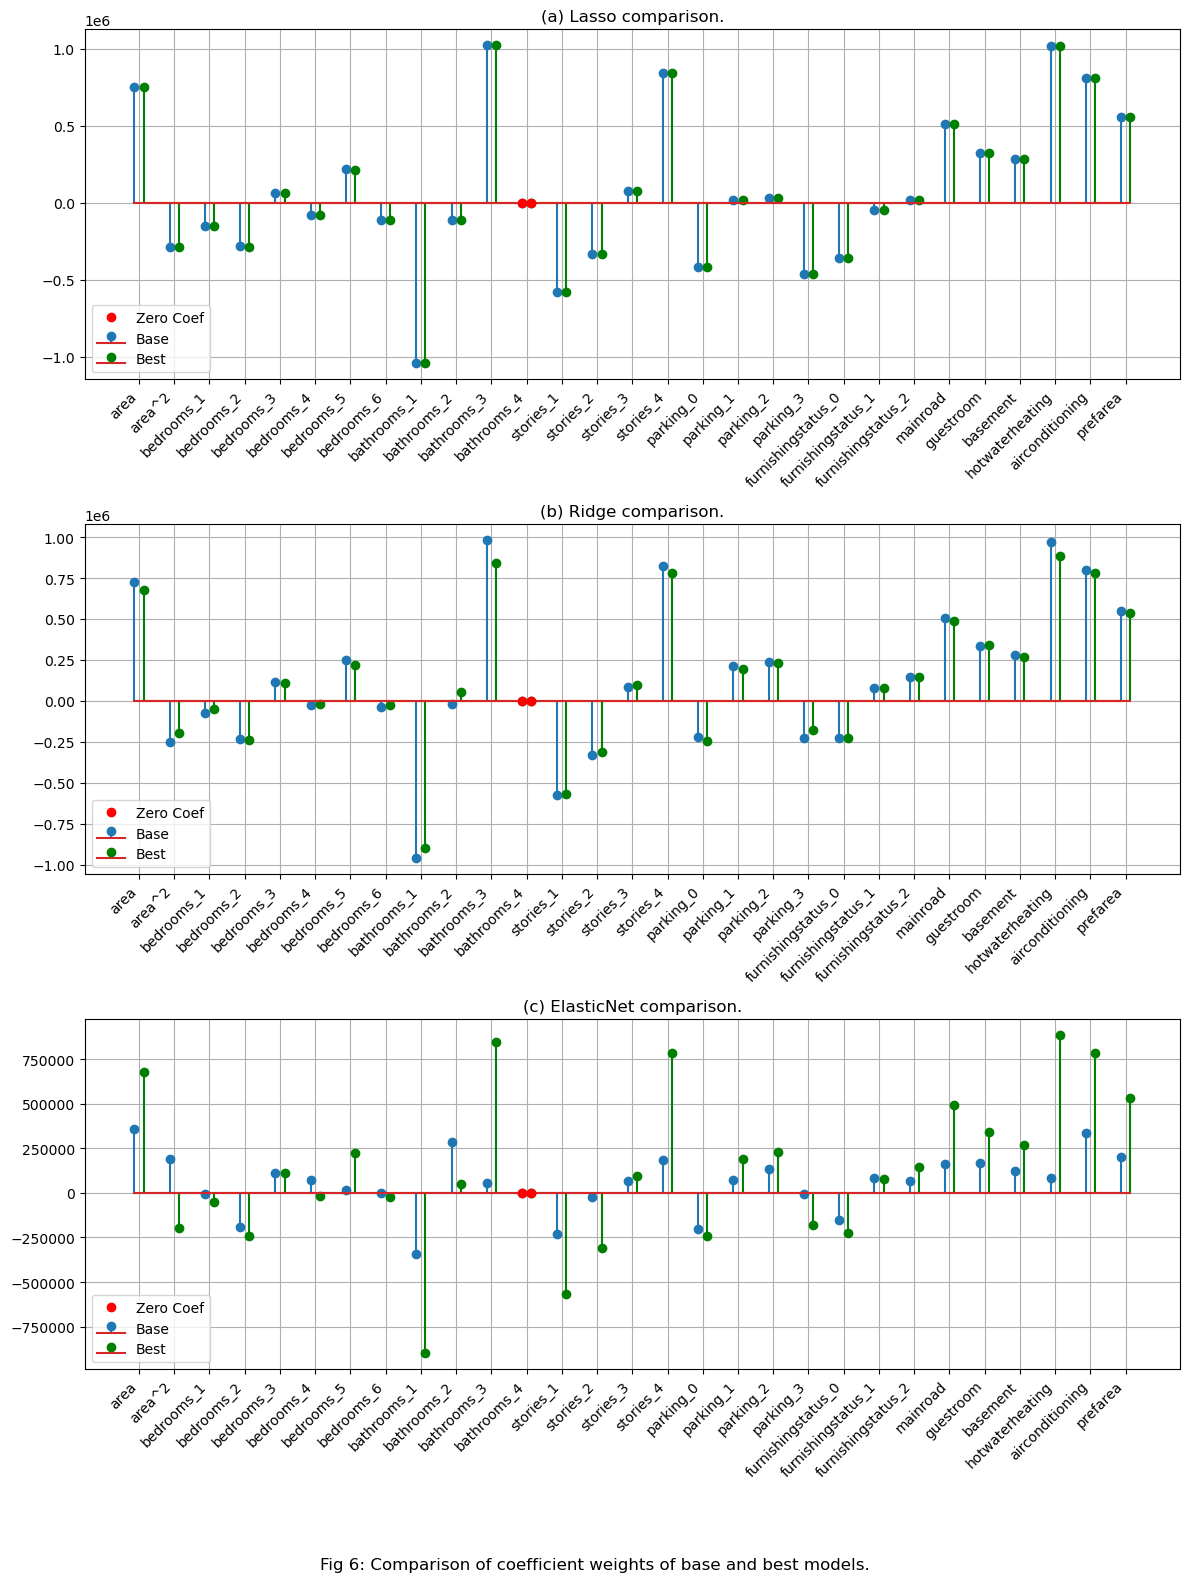

In [46]:
def plot_coefficients(feature_names, base_coef, best_coef, title, ax, offset=0.13, base_label='Base', best_label='Best'):

    x = np.arange(len(feature_names))

    ax.stem(x-offset, base_coef, label=base_label)
    ax.stem(x+offset, best_coef, linefmt='g', label=best_label)
    # Add special marker for coefficients with value 0
    zero_indices = np.where(base_coef == 0)[0]
    ax.plot(x[zero_indices]-offset, np.zeros_like(zero_indices), 'ro', label='Zero Coef')

    zero_indices = np.where(best_coef == 0)[0]
    ax.plot(x[zero_indices]+offset, np.zeros_like(zero_indices), 'ro')
    ax.grid()
    ax.set_xticks(x, feature_names, rotation=45, ha='right')
    ax.legend()
    ax.set_title(title)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 5*3), tight_layout=True)

plot_coefficients(feature_names=feature_names,
                  base_coef=lasso_base.coef_,
                  best_coef=lasso_best.coef_,
                  title="(a) Lasso comparison.",
                  ax=ax1)

plot_coefficients(feature_names=feature_names,
                  base_coef=ridge_base.coef_,
                  best_coef=ridge_best.coef_,
                  title="(b) Ridge comparison.",
                  ax=ax2)

plot_coefficients(feature_names=feature_names,
                  base_coef=elNet_base.coef_,
                  best_coef=elNet_best.coef_,
                  title="(c) ElasticNet comparison.",
                  ax=ax3)

fig.text(0.5, -0.05, "Fig 6: Comparison of coefficient weights of base and best models.", ha='center', fontsize=12)
plt.show()

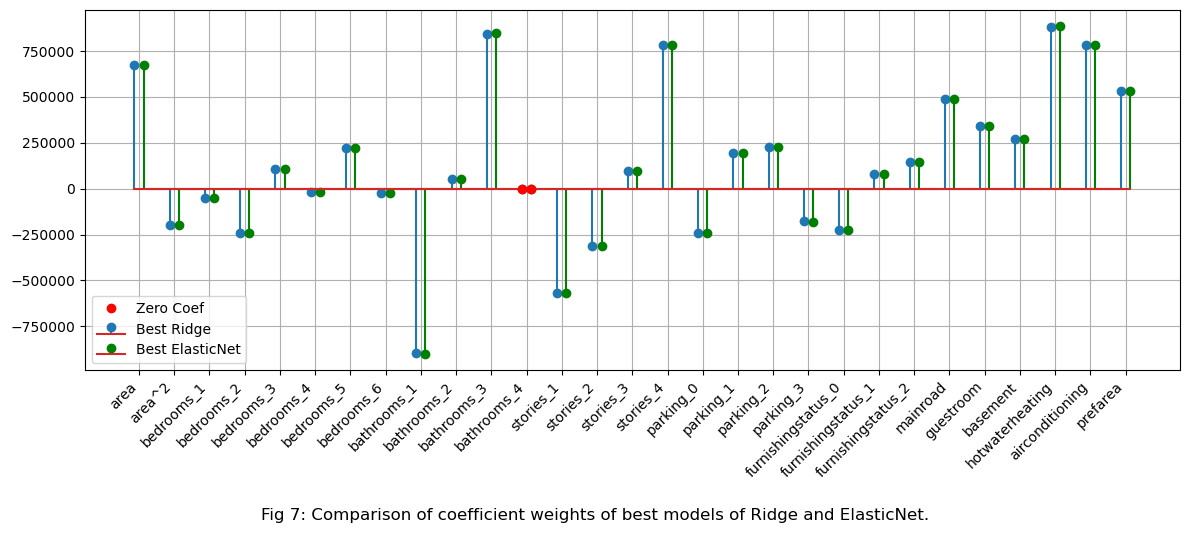

In [48]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12, 5*1), tight_layout=True)

plot_coefficients(feature_names=feature_names,
                  base_coef=ridge_best.coef_,
                  best_coef=elNet_best.coef_,
                  title="",
                  ax=ax1,
                  base_label='Best Ridge',
                  best_label='Best ElasticNet')

fig.text(0.5, -0.05, "Fig 7: Comparison of coefficient weights of best models of Ridge and ElasticNet.", ha='center', fontsize=12)
plt.show()

## 2.4 Residual analysis

A hypotesis of all the models applied in this notebook is to have errors normally distributed. A residual is the difference between the predicted value and the true value of a sample, $res = y-\hat{y};\ where\ \hat{y}=predicted\ value$. For the following analysis we select the best verion of the Lasso model.

Figure 8 shows the comparison between residuals and predicted value. In the case the predicted is the same of true value the residual value is equal to zero. In general, a model with performances that is able to make good aproximation presents a graph with a cloud of points near to $0$. In our case there are datapoints with a residual value higher than $3e^{6}$. Hence, even our best model is not able to catch all the relationship of features with the target variable. A possible solution is to define new variables with clustering methods, use non-linear models like trees, or collect more data.

Figure 9 shows the distribution of residuals, the shape is similar to a bell, but with heavy tails. Moreover, Figure 10 presents the qq plot of residuals and it is possible to appreciate the fact they do not follow a normal distribution.

/Users/lorenzopusateri/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


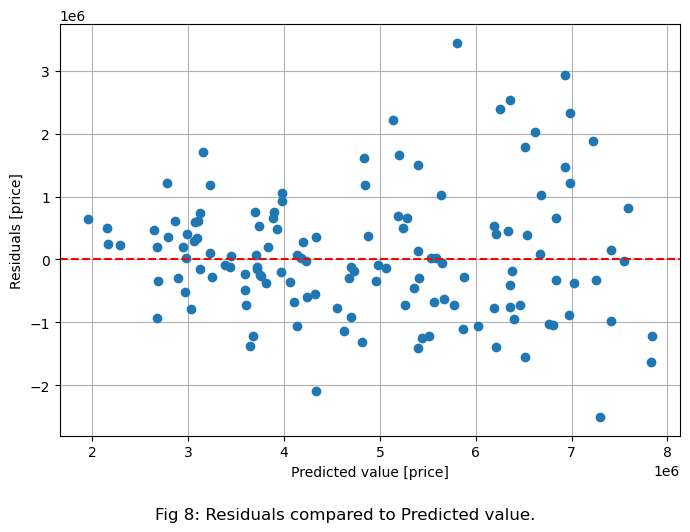

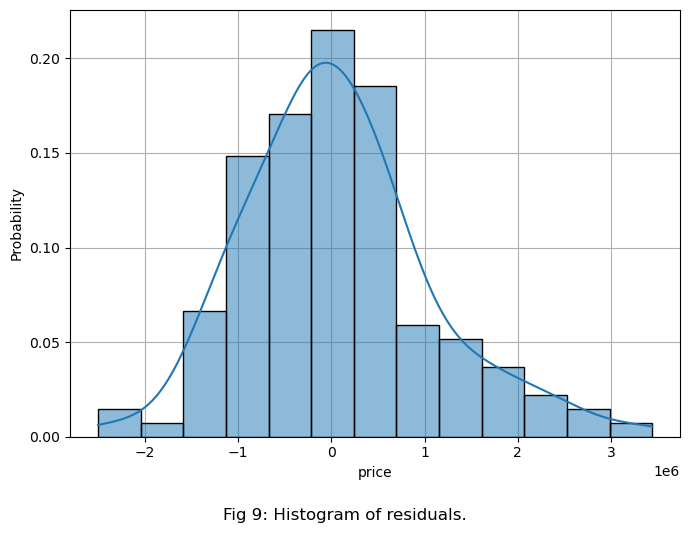

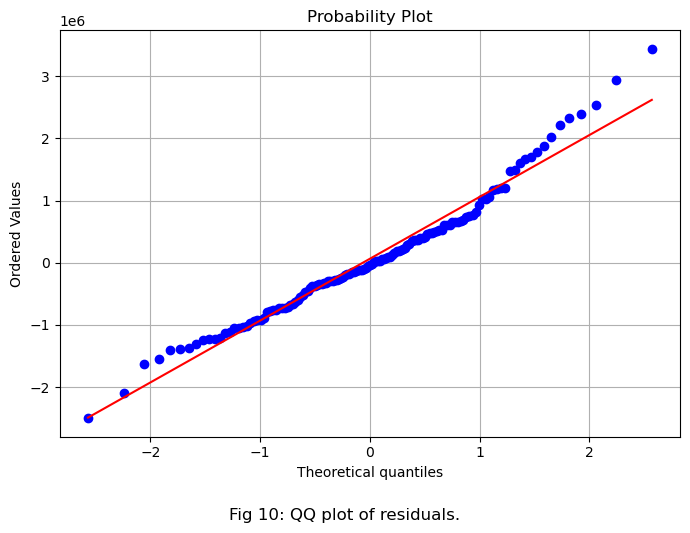

In [56]:
y_pred = lasso_best.predict(X_test)
res_lasso_best = y_test-y_pred

# residuals vs y_pred
fig = plt.figure(figsize=(7,5), tight_layout=True)
plt.scatter(y_pred, res_lasso_best, zorder=2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted value [price]')
plt.ylabel('Residuals [price]')
plt.grid()
fig.text(0.5, -0.05, "Fig 8: Residuals compared to Predicted value.", ha='center', fontsize=12)

# histogram of residuals
fig = plt.figure(figsize=(7,5), tight_layout=True)
sns.histplot(res_lasso_best, stat='probability', kde=True, zorder=2)
plt.grid()
fig.text(0.5, -0.05, "Fig 9: Histogram of residuals.", ha='center', fontsize=12)

fig = plt.figure(figsize=(7,5), tight_layout=True)
stats.probplot(res_lasso_best, dist="norm", plot=plt)
plt.grid()
fig.text(0.5, -0.05, "Fig 10: QQ plot of residuals.", ha='center', fontsize=12)
plt.show()

## 2.5 Regularization effects on coefficients

This section presents three figures that plot coefficients for multiple values of $\lambda$ ($[1, 10, 10^2, 10^3, 10^4, 10^5, 10^6]$) for `Lasso` (Figure 11), `Ridge` (Figure 12), and `ElasticNet` (Figure 13).

In the case of $\lambda=10^6$ all the coefficients of `Lasso` have value zero, while for `Ridge` the only coefficient with value zero correspond to the feature `bathrooms_4` and for the `ElasticNet` the non-zero coefficients are related to features `area` and `area^2`.

The $R^2$ score for Lasso decade with $\lambda=10^5$, whereas for `Ridge` and `ElasticNet` decade faster, with values of $\lambda$ equals to $10^2$ and $10$ respectively.

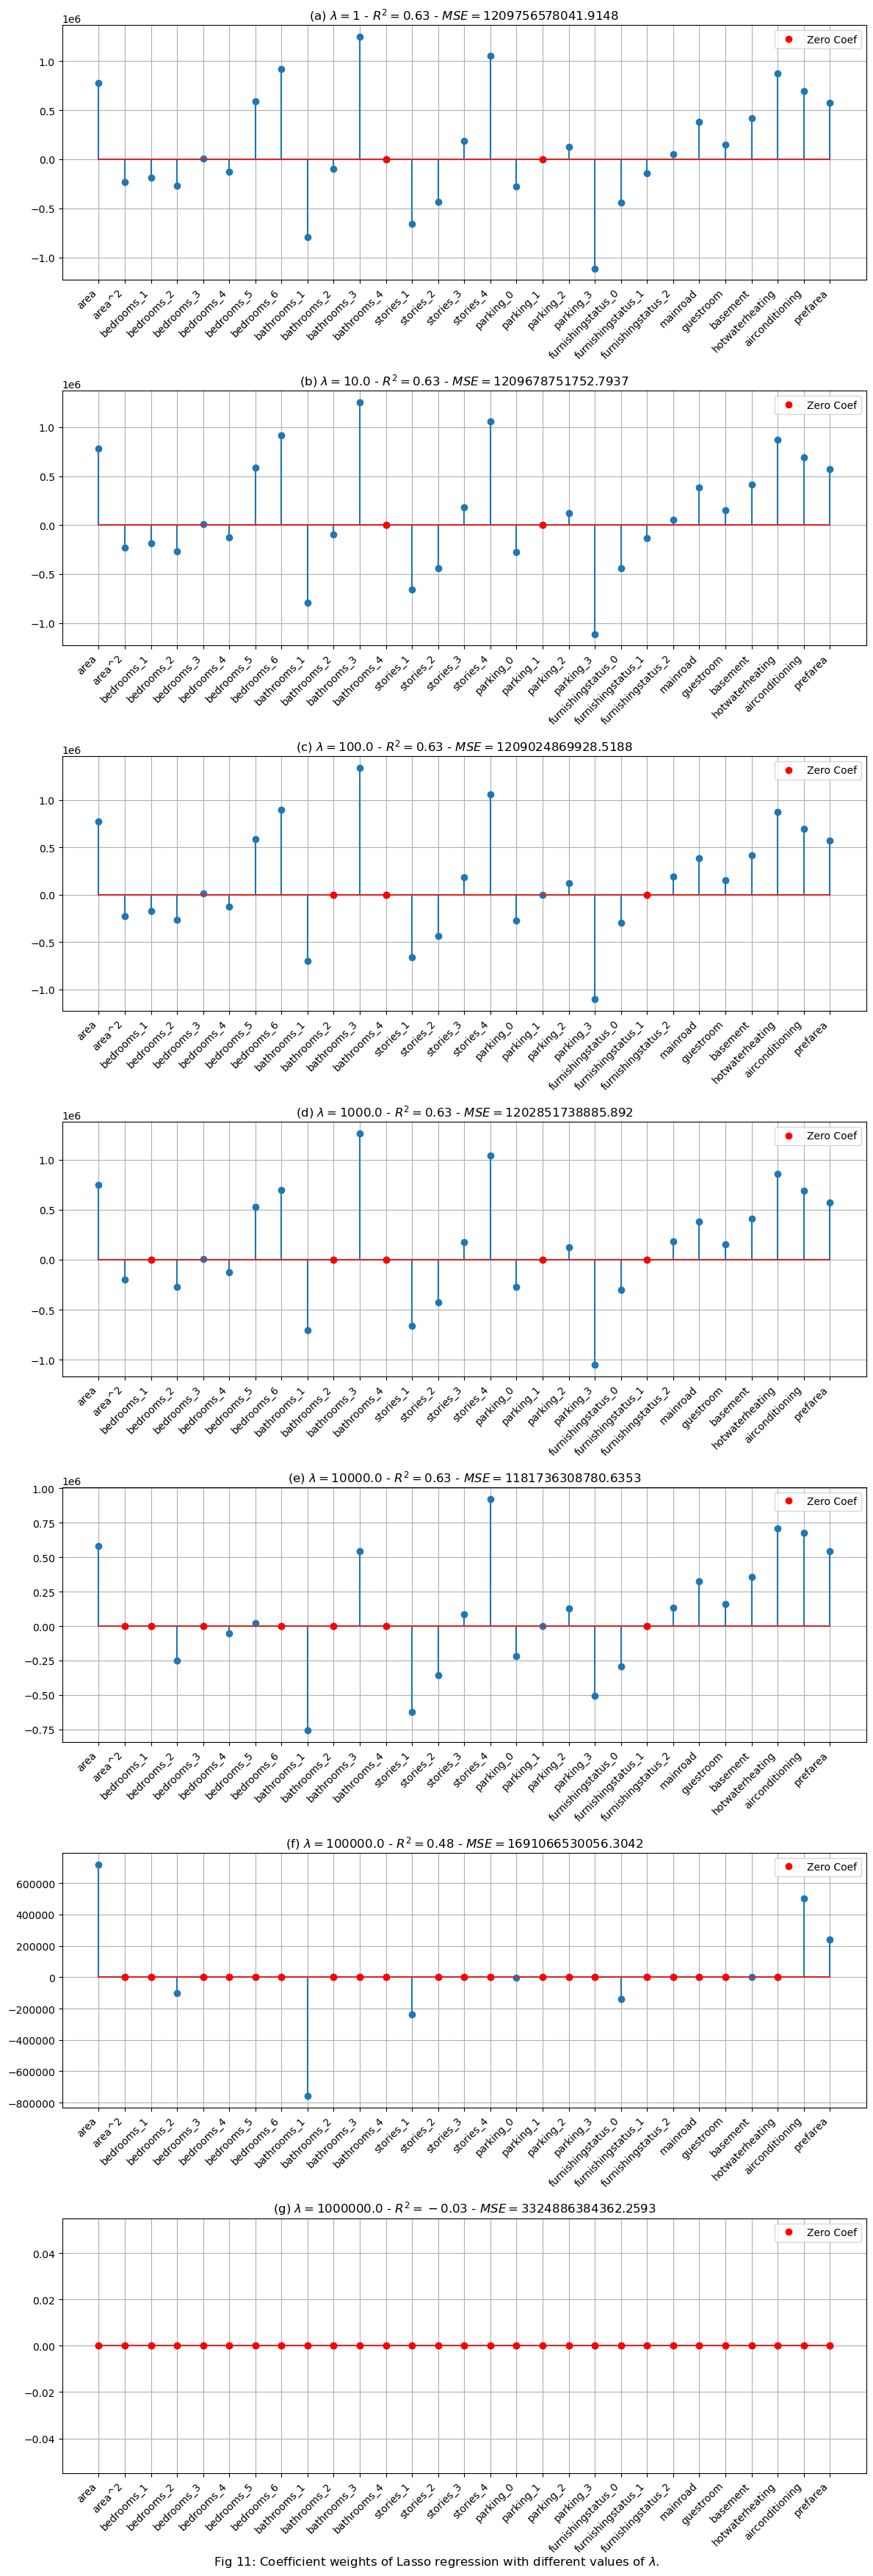

In [67]:
lambdas = [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
numerate_fig = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

x = np.arange(len(feature_names))

fig, axs = plt.subplots(nrows=len(lambdas), ncols=1,
                        figsize=(12, 5*len(lambdas)),
                        tight_layout=True)

for i, (l, ax) in enumerate(zip(lambdas, axs)):
    mdl = Lasso(alpha=l)

    mdl.fit(X_train, y_train)

    r2 = r2_score(y_test, mdl.predict(X_test))
    mse = mean_squared_error(y_test, mdl.predict(X_test))
    

    ax.stem(x, mdl.coef_)
    # Add special marker for coefficients with value 0
    zero_indices = np.where(mdl.coef_ == 0)[0]
    ax.plot(x[zero_indices], np.zeros_like(zero_indices), 'ro', label='Zero Coef')
    ax.grid()
    ax.set_xticks(x, feature_names, rotation=45, ha='right')
    ax.legend()
    ax.set_title(rf"({numerate_fig[i]}) $\lambda={l}$ - $R^2={round(r2, 2)}$ - $MSE = {mse}$")

fig.text(0.5, 0, r"Fig 11: Coefficient weights of Lasso regression with different values of $\lambda$.", ha='center', fontsize=12)
plt.show()

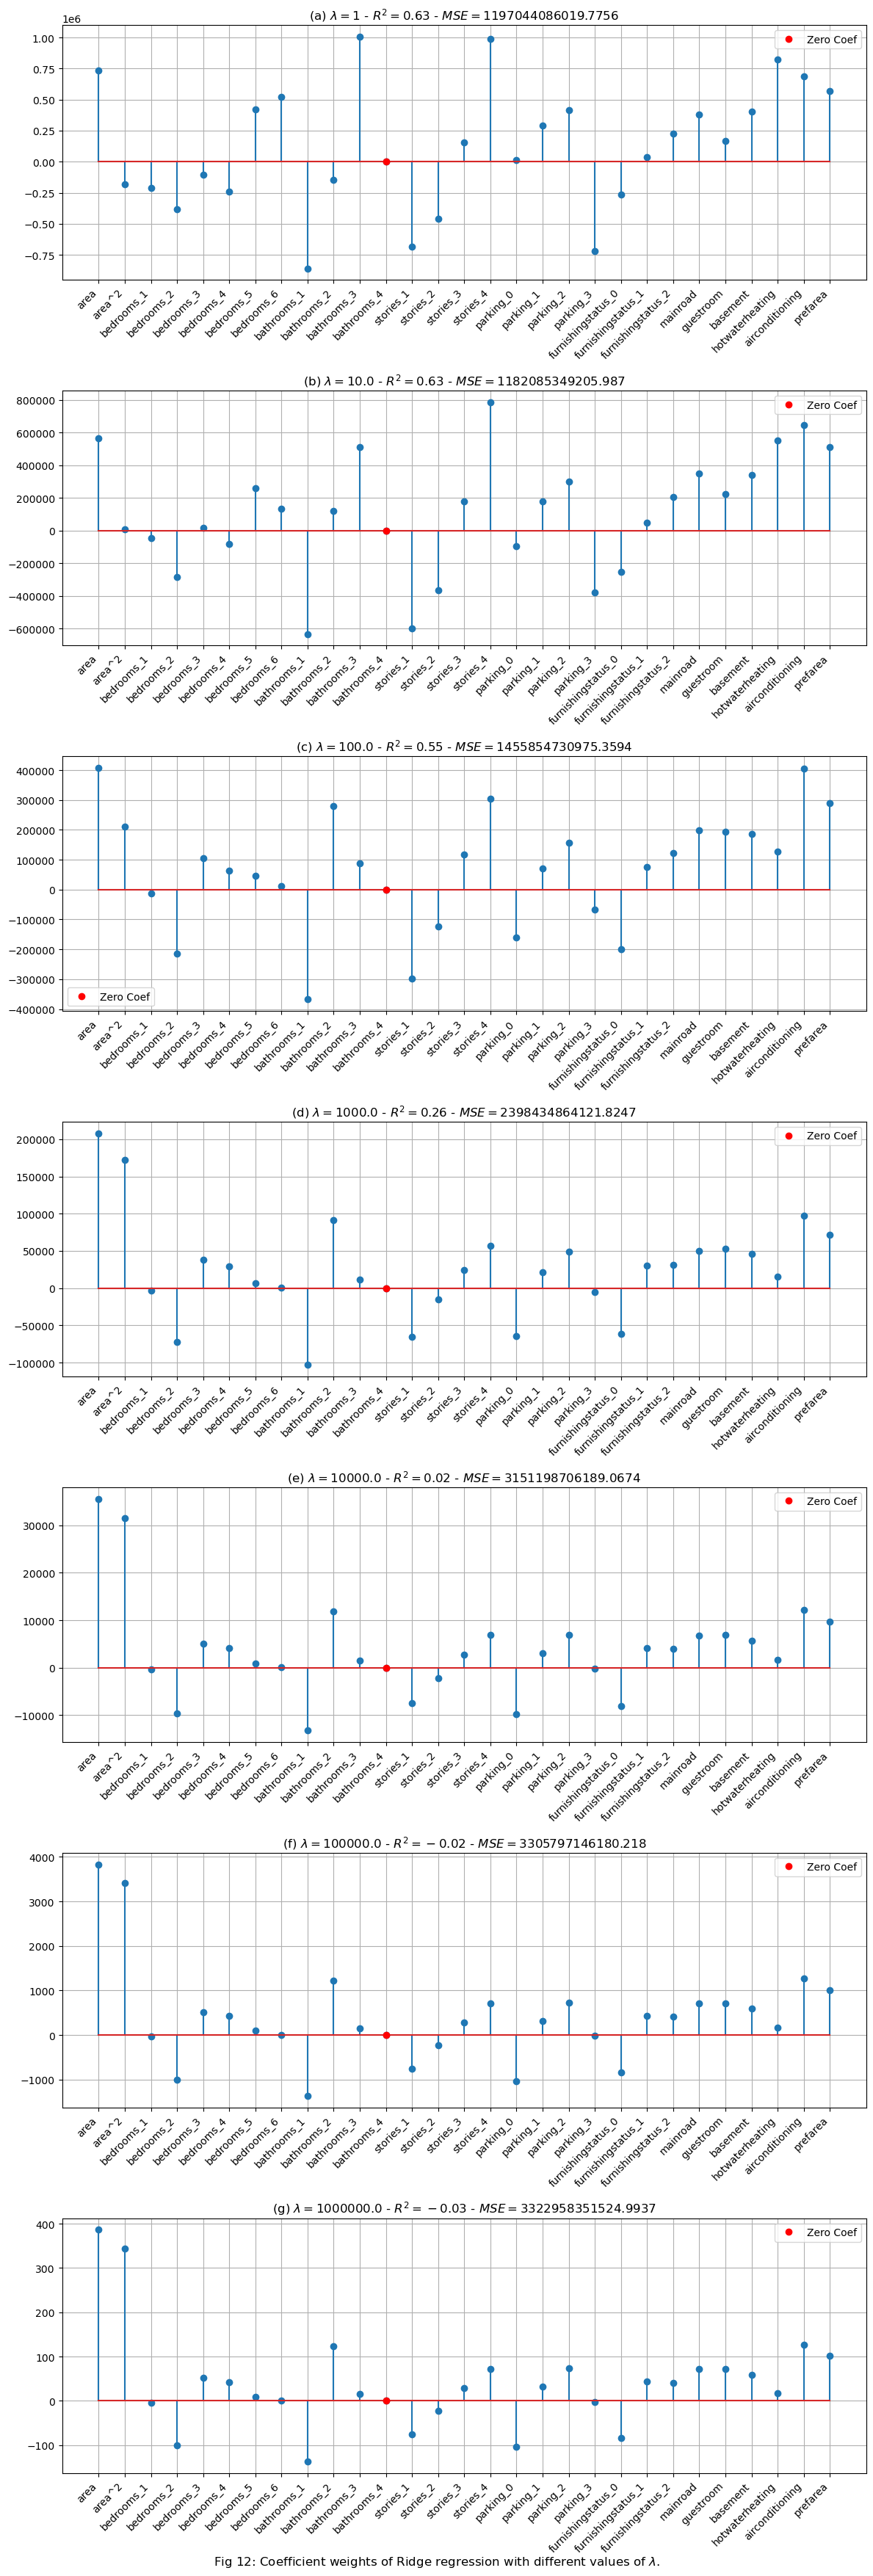

In [69]:
lambdas = [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
numerate_fig = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

x = np.arange(len(feature_names))

fig, axs = plt.subplots(nrows=len(lambdas), ncols=1,
                        figsize=(12, 5*len(lambdas)),
                        tight_layout=True)

for i, (l, ax) in enumerate(zip(lambdas, axs)):
    mdl = Ridge(alpha=l)

    mdl.fit(X_train, y_train)

    r2 = r2_score(y_test, mdl.predict(X_test))
    mse = mean_squared_error(y_test, mdl.predict(X_test))
    

    ax.stem(x, mdl.coef_)
    # Add special marker for coefficients with value 0
    zero_indices = np.where(mdl.coef_ == 0)[0]
    ax.plot(x[zero_indices], np.zeros_like(zero_indices), 'ro', label='Zero Coef')
    ax.grid()
    ax.set_xticks(x, feature_names, rotation=45, ha='right')
    ax.legend()
    ax.set_title(rf"({numerate_fig[i]}) $\lambda={l}$ - $R^2={round(r2, 2)}$ - $MSE = {mse}$")

fig.text(0.5, 0, r"Fig 12: Coefficient weights of Ridge regression with different values of $\lambda$.", ha='center', fontsize=12)
plt.show()

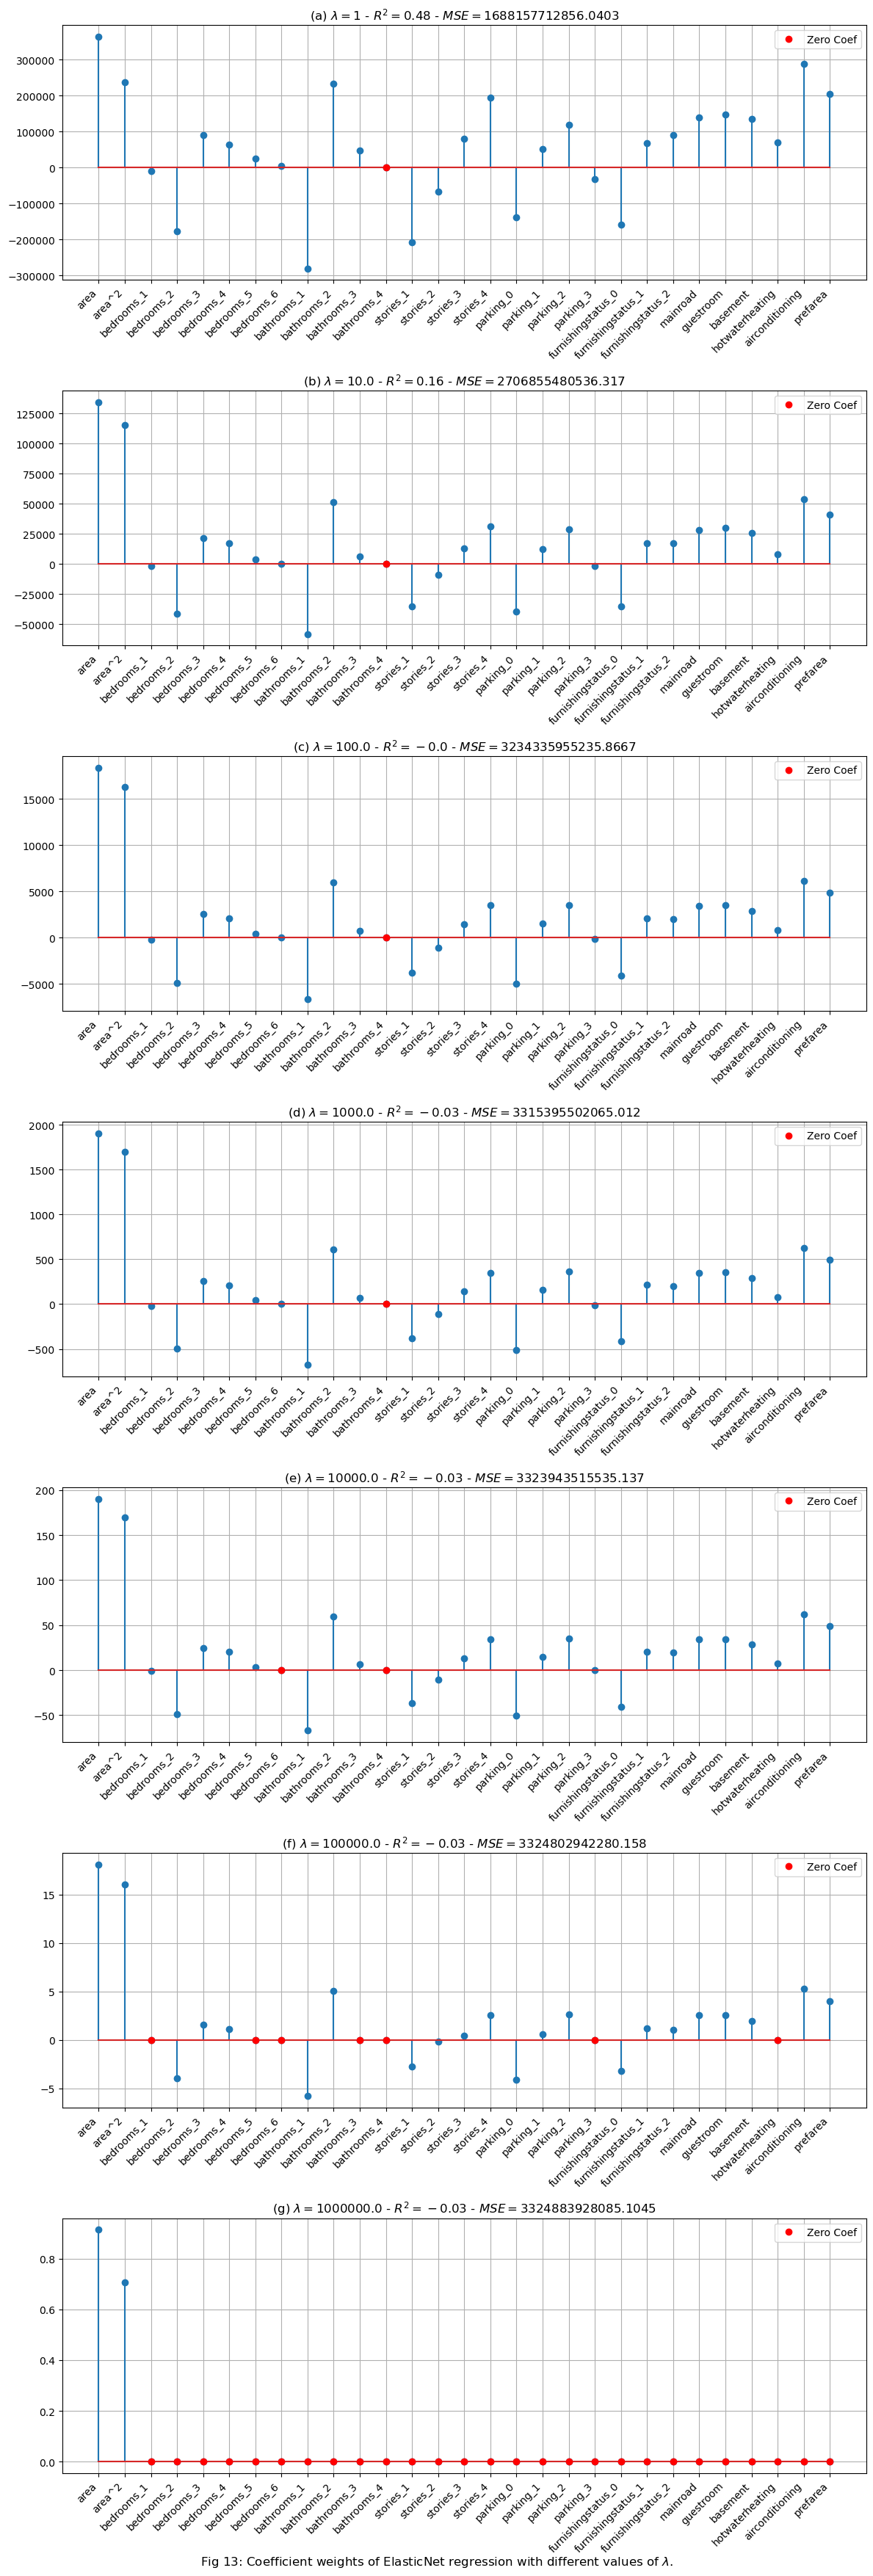

In [71]:
lambdas = [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
numerate_fig = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

x = np.arange(len(feature_names))

fig, axs = plt.subplots(nrows=len(lambdas), ncols=1,
                        figsize=(12, 5*len(lambdas)),
                        tight_layout=True)

for i, (l, ax) in enumerate(zip(lambdas, axs)):
    mdl = ElasticNet(alpha=l)

    mdl.fit(X_train, y_train)

    r2 = r2_score(y_test, mdl.predict(X_test))
    mse = mean_squared_error(y_test, mdl.predict(X_test))
    

    ax.stem(x, mdl.coef_)
    # Add special marker for coefficients with value 0
    zero_indices = np.where(mdl.coef_ == 0)[0]
    ax.plot(x[zero_indices], np.zeros_like(zero_indices), 'ro', label='Zero Coef')
    ax.grid()
    ax.set_xticks(x, feature_names, rotation=45, ha='right')
    ax.legend()
    ax.set_title(rf"({numerate_fig[i]}) $\lambda={l}$ - $R^2={round(r2, 2)}$ - $MSE = {mse}$")

fig.text(0.5, 0, r"Fig 13: Coefficient weights of ElasticNet regression with different values of $\lambda$.", ha='center', fontsize=12)
plt.show()